# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
# sklearn dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
# imblearn dependencies
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

## Deliverable 1

### Read the CSV and Perform Basic Data Cleaning

In [5]:
# read csv
file_path = Path('./data/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,60 months,17.19%,499.10,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,21225.0,21225.0,21225.0,60 months,14.74%,502.05,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000.0,5000.0,5000.0,36 months,17.97%,180.69,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,8.19%,628.49,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,12000.0,12000.0,12000.0,60 months,15.57%,289.09,C,C3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115675 entries, 0 to 115674
Columns: 144 entries, id to settlement_term
dtypes: float64(117), object(27)
memory usage: 127.1+ MB


In [7]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [8]:
print(len(columns))

86


In [9]:
# Load the data
loans_df = df.loc[:, columns].copy()
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,20000.0,17.19%,499.10,RENT,47000.0,Source Verified,Mar-2019,Issued,n,14.02,...,98.0,12.5,0.0,0.0,75824.0,31546.0,33800.0,21524.0,N,N
1,21225.0,14.74%,502.05,MORTGAGE,225000.0,Not Verified,Mar-2019,Issued,n,16.80,...,100.0,50.0,1.0,0.0,747075.0,209426.0,53500.0,128175.0,N,N
2,5000.0,17.97%,180.69,MORTGAGE,62000.0,Not Verified,Mar-2019,Issued,n,19.82,...,66.7,50.0,0.0,0.0,255738.0,31615.0,9400.0,39938.0,N,N
3,20000.0,8.19%,628.49,MORTGAGE,200000.0,Not Verified,Mar-2019,Issued,n,22.66,...,95.7,22.2,0.0,0.0,448069.0,84744.0,49400.0,105180.0,N,N
4,12000.0,15.57%,289.09,MORTGAGE,49000.0,Source Verified,Mar-2019,Issued,n,13.47,...,86.1,14.3,0.0,0.0,189260.0,106025.0,24400.0,68860.0,N,N


In [10]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115675 entries, 0 to 115674
Data columns (total 86 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   115675 non-null  float64
 1   int_rate                    115675 non-null  object 
 2   installment                 115675 non-null  float64
 3   home_ownership              115675 non-null  object 
 4   annual_inc                  115675 non-null  float64
 5   verification_status         115675 non-null  object 
 6   issue_d                     115675 non-null  object 
 7   loan_status                 115675 non-null  object 
 8   pymnt_plan                  115675 non-null  object 
 9   dti                         115418 non-null  float64
 10  delinq_2yrs                 115675 non-null  float64
 11  inq_last_6mths              115675 non-null  float64
 12  open_acc                    115675 non-null  float64
 13  pub_rec       

In [11]:
# Drop the null columns where all values are null
loans_df = loans_df.dropna(axis='columns', how='all')
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,20000.0,17.19%,499.10,RENT,47000.0,Source Verified,Mar-2019,Issued,n,14.02,...,98.0,12.5,0.0,0.0,75824.0,31546.0,33800.0,21524.0,N,N
1,21225.0,14.74%,502.05,MORTGAGE,225000.0,Not Verified,Mar-2019,Issued,n,16.80,...,100.0,50.0,1.0,0.0,747075.0,209426.0,53500.0,128175.0,N,N
2,5000.0,17.97%,180.69,MORTGAGE,62000.0,Not Verified,Mar-2019,Issued,n,19.82,...,66.7,50.0,0.0,0.0,255738.0,31615.0,9400.0,39938.0,N,N
3,20000.0,8.19%,628.49,MORTGAGE,200000.0,Not Verified,Mar-2019,Issued,n,22.66,...,95.7,22.2,0.0,0.0,448069.0,84744.0,49400.0,105180.0,N,N
4,12000.0,15.57%,289.09,MORTGAGE,49000.0,Source Verified,Mar-2019,Issued,n,13.47,...,86.1,14.3,0.0,0.0,189260.0,106025.0,24400.0,68860.0,N,N


In [12]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115675 entries, 0 to 115674
Data columns (total 86 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   115675 non-null  float64
 1   int_rate                    115675 non-null  object 
 2   installment                 115675 non-null  float64
 3   home_ownership              115675 non-null  object 
 4   annual_inc                  115675 non-null  float64
 5   verification_status         115675 non-null  object 
 6   issue_d                     115675 non-null  object 
 7   loan_status                 115675 non-null  object 
 8   pymnt_plan                  115675 non-null  object 
 9   dti                         115418 non-null  float64
 10  delinq_2yrs                 115675 non-null  float64
 11  inq_last_6mths              115675 non-null  float64
 12  open_acc                    115675 non-null  float64
 13  pub_rec       

In [13]:
# Drop the null rows
loans_df = loans_df.dropna()
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,20000.0,17.19%,499.10,RENT,47000.0,Source Verified,Mar-2019,Issued,n,14.02,...,98.0,12.5,0.0,0.0,75824.0,31546.0,33800.0,21524.0,N,N
1,21225.0,14.74%,502.05,MORTGAGE,225000.0,Not Verified,Mar-2019,Issued,n,16.80,...,100.0,50.0,1.0,0.0,747075.0,209426.0,53500.0,128175.0,N,N
3,20000.0,8.19%,628.49,MORTGAGE,200000.0,Not Verified,Mar-2019,Issued,n,22.66,...,95.7,22.2,0.0,0.0,448069.0,84744.0,49400.0,105180.0,N,N
4,12000.0,15.57%,289.09,MORTGAGE,49000.0,Source Verified,Mar-2019,Issued,n,13.47,...,86.1,14.3,0.0,0.0,189260.0,106025.0,24400.0,68860.0,N,N
6,25000.0,7.02%,772.16,MORTGAGE,305000.0,Not Verified,Mar-2019,Issued,n,8.16,...,100.0,0.0,0.0,0.0,840287.0,65339.0,81000.0,38858.0,N,N


In [14]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82537 entries, 0 to 115673
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   82537 non-null  float64
 1   int_rate                    82537 non-null  object 
 2   installment                 82537 non-null  float64
 3   home_ownership              82537 non-null  object 
 4   annual_inc                  82537 non-null  float64
 5   verification_status         82537 non-null  object 
 6   issue_d                     82537 non-null  object 
 7   loan_status                 82537 non-null  object 
 8   pymnt_plan                  82537 non-null  object 
 9   dti                         82537 non-null  float64
 10  delinq_2yrs                 82537 non-null  float64
 11  inq_last_6mths              82537 non-null  float64
 12  open_acc                    82537 non-null  float64
 13  pub_rec                     82

In [15]:
loans_df['loan_status'].value_counts()

Current               68470
Issued                13720
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [16]:
# Remove the `Issued` loan status
issued_mask = loans_df['loan_status'] != 'Issued'
loans_df = loans_df.loc[issued_mask]
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
93,10500.0,17.19%,375.35,RENT,66000.0,Source Verified,Mar-2019,Current,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
99,25000.0,20.00%,929.09,MORTGAGE,105000.0,Verified,Mar-2019,Current,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
132,20000.0,20.00%,529.88,MORTGAGE,56000.0,Verified,Mar-2019,Current,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
133,10000.0,16.40%,353.55,RENT,92000.0,Verified,Mar-2019,Current,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
140,22000.0,14.74%,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,Current,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [17]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68817 entries, 93 to 115673
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  object 
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     6

In [18]:
loans_df['loan_status'].value_counts()

Current               68470
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [19]:
# Convert the target column values to low_risk and high_risk based on their values
# current = low risk
x = {'Current': 'low_risk'}   
loans_df = loans_df.replace(x)
loans_df['loan_status'].value_counts()

low_risk              68470
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [20]:
# late, default, in grace period = high risk
x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
loans_df = loans_df.replace(x)
loans_df['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [21]:
# look at df
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
93,10500.0,17.19%,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
99,25000.0,20.00%,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
132,20000.0,20.00%,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
133,10000.0,16.40%,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
140,22000.0,14.74%,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [22]:
# convert interest rate to numerical
loans_df['int_rate'] = loans_df['int_rate'].str.replace('%', '')
loans_df['int_rate'] = loans_df['int_rate'].astype('float') / 100
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
93,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
99,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
132,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
133,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
140,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [23]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68817 entries, 93 to 115673
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     6

In [24]:
loans_df.shape

(68817, 86)

In [25]:
# determine columns that are currently categorical instead of numerical
columns_obj = loans_df.select_dtypes(include='object').columns
columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [26]:
print(len(columns_obj))

10


In [27]:
# examine home_ownership
loans_df['home_ownership'].value_counts()

MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64

In [28]:
# examine all the columns
for column in loans_df[columns_obj]:
    print(column, "\n", loans_df[column].value_counts())
    print("------------------")

home_ownership 
 MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64
------------------
verification_status 
 Not Verified       32895
Source Verified    25737
Verified           10185
Name: verification_status, dtype: int64
------------------
issue_d 
 Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64
------------------
loan_status 
 low_risk     68470
high_risk      347
Name: loan_status, dtype: int64
------------------
pymnt_plan 
 n    68817
Name: pymnt_plan, dtype: int64
------------------
initial_list_status 
 w    60292
f     8525
Name: initial_list_status, dtype: int64
------------------
next_pymnt_d 
 May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64
------------------
application_type 
 Individual    59206
Joint App      9611
Name: application_type, dtype: int64
------------------
hardship_flag 
 N    68817
Name: hardship_flag, dtype: int64
------------------
debt_settlem

In [29]:
# drop columns that only include 1 value in value_counts()
loans_df = loans_df.drop(columns=['debt_settlement_flag', 'hardship_flag', 'pymnt_plan'])
loans_df.shape

(68817, 83)

In [30]:
# reset index
loans_df.reset_index(inplace=True, drop=True)
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [31]:
# save our loans_df as clean_loans_df csv file
clean_loans_df = loans_df

clean_loans_df.to_csv("./data/clean_loans.csv", index=False)

### Split the Data into Training and Testing

In [32]:
# read in the csv file
df = pd.read_csv("./data/clean_loans.csv")
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [33]:
# Create our features
X = df.drop(columns='loan_status')
X.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,dti,delinq_2yrs,inq_last_6mths,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,27.24,0.0,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,20.23,0.0,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,24.26,0.0,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,31.44,0.0,1.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,18.76,0.0,1.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [34]:
# Create our target
y = df['loan_status']
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [35]:
X.shape

(68817, 82)

In [36]:
# use get_dummies
X_encoded = pd.get_dummies(X)
X_encoded.shape

(68817, 92)

In [37]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 92 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            68817 non-null  float64
 1   int_rate                             68817 non-null  float64
 2   installment                          68817 non-null  float64
 3   annual_inc                           68817 non-null  float64
 4   dti                                  68817 non-null  float64
 5   delinq_2yrs                          68817 non-null  float64
 6   inq_last_6mths                       68817 non-null  float64
 7   open_acc                             68817 non-null  float64
 8   pub_rec                              68817 non-null  float64
 9   revol_bal                            68817 non-null  float64
 10  total_acc                            68817 non-null  float64
 11  out_prncp                   

In [38]:
X_encoded.shape

(68817, 92)

In [39]:
y.shape

(68817,)

In [40]:
# scale and normalize X_encoded
data_scaler = StandardScaler()

In [41]:
# fit transform
X_encoded_scaled = data_scaler.fit_transform(X_encoded)
X_encoded_scaled[:1]

array([[-0.60109272,  0.91798436, -0.36555835, -0.1921948 ,  0.27040056,
        -0.30314253, -0.65649151, -0.76165917, -0.37420432, -0.73252183,
        -0.8658573 , -0.58124513, -0.58081958, -0.50046544, -0.50029335,
        -0.3228639 , -0.89960419, -0.03227363,  0.        ,  0.        ,
        -0.17383528, -0.12011247,  0.        ,  0.        , -0.00589695,
        -0.72692228,  1.67997825,  0.2392533 ,  1.19137226,  1.35299632,
        -0.80895603, -0.13418715, -0.45717571, -0.16310175, -0.24864022,
        -0.83203994,  0.12422197, -1.04213361, -0.24758239, -0.59166015,
         0.75578041,  0.37274923, -0.59052419, -0.80915288,  1.04494582,
        -0.07820908, -0.00778953, -0.56994022, -0.7981628 , -0.64845959,
        -0.66313947, -0.8249868 , -0.14674317, -1.10824038, -0.33490355,
        -1.13862411, -1.05103022, -1.27998521, -1.40011594,  0.06599699,
        -1.11347944, -1.31043257, -1.0519437 , -0.75930693,  0.        ,
         0.        , -0.13347217,  0.41138923, -1.1

In [42]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state=1)
Counter(y_train)

Counter({'low_risk': 51366, 'high_risk': 246})

In [43]:
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

In [44]:
# imbalance
print(246/51366)

0.004789160144842892


In [45]:
# get baseline of performance using logistics regression model
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [46]:
# fit (train) our model with our data
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [47]:
# predict
y_pred = classifier.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [48]:
# view the data
pd.DataFrame({'Prediction': y_pred, 'actual': y_test})

,Prediction,actual
7034,low_risk,low_risk
38804,low_risk,low_risk
65533,low_risk,low_risk
37736,low_risk,low_risk
6390,low_risk,low_risk
...,...,...
31854,low_risk,low_risk
27835,low_risk,low_risk
3089,low_risk,low_risk
43343,low_risk,low_risk


In [49]:
# calculate accuracy score
accuracy_score(y_test, y_pred)

0.995059575704737

In [50]:
# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[   21    80]
 [    5 17099]]


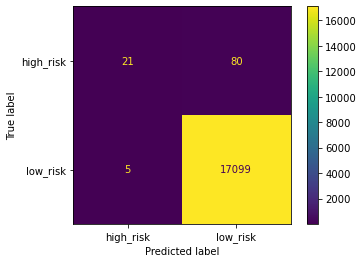

In [51]:
# ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classifier.classes_)
disp.plot()

In [52]:
# print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.81      0.21      0.33       101
    low_risk       1.00      1.00      1.00     17104

    accuracy                           1.00     17205
   macro avg       0.90      0.60      0.66     17205
weighted avg       0.99      1.00      0.99     17205



In [53]:
# print imbalanced classification report
imb_report = classification_report_imbalanced(y_test, y_pred)
print(imb_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      0.21      1.00      0.33      0.46      0.19       101
   low_risk       1.00      1.00      0.21      1.00      0.46      0.22     17104

avg / total       0.99      1.00      0.21      0.99      0.46      0.22     17205



### Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

#### Naive Random Oversampling

In [54]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state = 1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [55]:
# Train the Logistic Regression model using the resampled data
# model
model = LogisticRegression(solver = 'lbfgs', random_state = 1)

# fit
model.fit(X_resampled, y_resampled)

# predict
y_pred = model.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [56]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[   83    18]
 [ 2680 14424]]


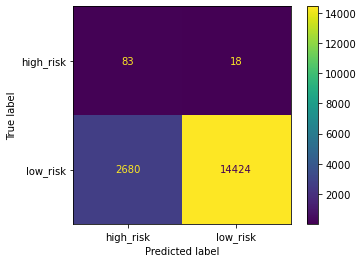

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()

In [58]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8325468421491353

In [59]:
# Print the imbalanced classification report
# base high_risk       0.81      0.21      1.00      0.33 
imb_report = classification_report_imbalanced(y_test, y_pred)
print(imb_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.84      0.06      0.83      0.69       101
   low_risk       1.00      0.84      0.82      0.91      0.83      0.69     17104

avg / total       0.99      0.84      0.82      0.91      0.83      0.69     17205



#### SMOTE Oversampling

In [60]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
    sampling_strategy='auto').fit_resample(
    X_train, y_train)

Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [61]:
# Train the Logistic Regression model using the resampled data
# model
model = LogisticRegression(solver = 'lbfgs', random_state = 1)

# fit
model.fit(X_resampled, y_resampled)

# predict
y_pred = model.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [62]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[   83    18]
 [ 2285 14819]]


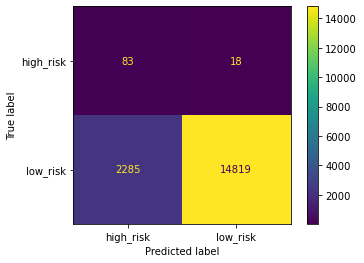

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()

In [64]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8440938486973113

In [65]:
# Print the imbalanced classification report
# base              high_risk       0.81      0.21      1.00      0.33 
# random_oversample high_risk       0.03      0.82      0.84      0.06
imb_report = classification_report_imbalanced(y_test, y_pred)
print(imb_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



### Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [66]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [67]:
# Train the Logistic Regression model using the resampled data
# model
model = LogisticRegression(solver = 'lbfgs', random_state = 1)

# fit
model.fit(X_resampled, y_resampled)

# predict
y_pred = model.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'high_risk',
       'low_risk'], dtype=object)

In [68]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[   89    12]
 [ 4112 12992]]


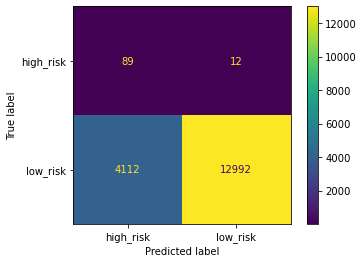

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()

In [70]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8203882595930314

In [71]:
# Print the imbalanced classification report
# base              high_risk       0.81      0.21      1.00      0.33 
# random_oversample high_risk       0.03      0.82      0.84      0.06
# smote             high_risk       0.04      0.82      0.87      0.07
imb_report = classification_report_imbalanced(y_test, y_pred)
print(imb_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.88      0.76      0.04      0.82      0.68       101
   low_risk       1.00      0.76      0.88      0.86      0.82      0.66     17104

avg / total       0.99      0.76      0.88      0.86      0.82      0.66     17205



## Deliverable 2

### Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [72]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [73]:
Counter(y_resampled)

Counter({'high_risk': 51366, 'low_risk': 47640})

In [74]:
# Train the Logistic Regression model using the resampled data
# model
model = LogisticRegression(solver = 'lbfgs', random_state = 1)

# fit
model.fit(X_resampled, y_resampled)

# predict
y_pred = model.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [75]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[   83    18]
 [ 2463 14641]]


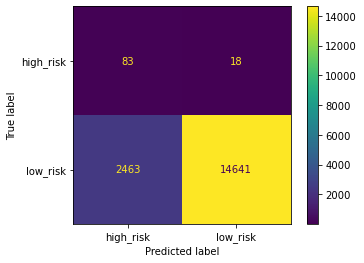

In [77]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot()

In [76]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8388903875186395

In [78]:
# Print the imbalanced classification report
# base              high_risk       0.81      0.21      1.00      0.33 
# random_oversample high_risk       0.03      0.82      0.84      0.06
# smote             high_risk       0.04      0.82      0.87      0.07
# undersample       high_risk       0.02      0.88      0.76      0.04
imb_report = classification_report_imbalanced(y_test, y_pred)
print(imb_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.86      0.06      0.84      0.70       101
   low_risk       1.00      0.86      0.82      0.92      0.84      0.71     17104

avg / total       0.99      0.86      0.82      0.92      0.84      0.71     17205

